<a href="https://colab.research.google.com/github/KVKTRAN/CANDEV_4044/blob/main/SlowZonesAndSpeed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Load Data

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# !pip install rasterio shapely

     |████████████████████████████████| 19.3 MB 6.1 MB/s 


In [9]:
import pandas as pd
import numpy as np
import folium 
from folium import plugins
import rasterio

path_ais = "/content/drive/MyDrive/data/AIS_2020_04_clean.csv"
path_tif = "/content/drive/MyDrive/data/NARW_Apr_Norm.tif"
path_sz = ["/content/drive/MyDrive/data/Block_Island_Sound_Nov_1-Apr_30.geojson", 
           "/content/drive/MyDrive/data/Cape_Cod_Bay_Jan_1-May_15.geojson", 
           "/content/drive/MyDrive/data/Great_South_Channel_Apr_1-Jul_31.geojson",
           "/content/drive/MyDrive/data/Off_Race_Point_Mar_1-Apr_30.geojson"
           ]

In [10]:
# Load ship data
df = pd.read_csv(path_ais)

# Load Raster data
raster_data = rasterio.open(path_tif)
raster = raster_data.read(1)

data = df[df['SOG'] > 30]
heat_df = data[['Lat', 'Lon', 'SOG']]
heat_df = heat_df.dropna(axis=0, subset=['Lat','Lon'])

# convert to heat data 
heat_data = [[row['Lat'], row['Lon'], row['SOG']] for index, row in heat_df.iterrows()]

In [11]:
dst_crs = 'EPSG:4326' 

# [[top, left], [bottom, right]]
# y_off = -1.5
# x_off = 0
y_off = 0
x_off = 0
map_bounds = [[raster_data.bounds.top+y_off, raster_data.bounds.left+x_off], [raster_data.bounds.bottom+y_off, raster_data.bounds.right+x_off]]

# create map
mymap = folium.Map(width=500, height=500, location=[heat_data[0][0], heat_data[0][1]], tiles="OpenStreetMap", zoom_start=2)

# add Heat map
plugins.HeatMap(heat_data).add_to(mymap)

def style_function(feature):
  if feature == 0:
    return (256,256,256,0)
  elif feature > 0.1:
    return (256,0,0,1)
  else:
    return (0,0,0,0.1)

# add raster layer to the map 
# raster variable is  what we load from rasterio defined above
folium.raster_layers.ImageOverlay(raster,
                                  bounds=map_bounds,
                                  colormap=lambda feature: (256,256,256,0) if feature == 0 else ((256,0,0,0.5) if feature > 0.1 else (0,0,0,0.1))
                                  ).add_to(mymap)

# Add the slow zones
folium.GeoJson(path_sz[0], name="geojson").add_to(mymap)
folium.GeoJson(path_sz[1], name="geojson").add_to(mymap)
folium.GeoJson(path_sz[2], name="geojson").add_to(mymap)
folium.GeoJson(path_sz[3], name="geojson").add_to(mymap)

# add layer control to the map
folium.LayerControl().add_to(mymap)

In [12]:
mymap

## Check if a Point is inside a Polygon




In [20]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.ops import unary_union

In [16]:
data = df[['Lat', 'Lon', 'SOG']]
data = data[data['SOG'] > 10]
data = data.reset_index()

In [ ]:
inSZ = []

geo_data = folium.GeoJson(path_sz[0], name="geojson")
feature = geo_data.data['features'][0]
coor = feature['geometry']['coordinates']
polygon = Polygon(coor[0])

# data['InSZ'] = inSZ
# print(data['Lat'][i])

In [ ]:
for i in range(0, len(data)):
  m_point = Point(data['Lon'][i], data['Lat'][i])
  if m_point.within(polygon): 
    inSZ.append(1)
  else: 
    inSZ.append(0)

data['InSZ'] = inSZ

In [14]:
# convert raster file to polygons data

import rasterio
from rasterio.features import shapes
mask = None
with rasterio.Env():
    with rasterio.open(path_tif) as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.transform)))
        
geoms = list(results)
# first feature
# print(geoms[0])

{'properties': {'raster_val': 0.08353134244680405}, 'geometry': {'type': 'Polygon', 'coordinates': [[(-67.14710462577482, 44.7730401785405), (-67.14710462577482, 44.65870634322167), (-66.91843695513715, 44.65870634322167), (-66.91843695513715, 44.7730401785405), (-67.14710462577482, 44.7730401785405)]]}}


## Display raster as Polygon on world map


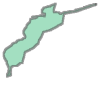

In [21]:
mymap = folium.Map(location=[data['Lat'][0], data['Lon'][0]], tiles="OpenStreetMap", zoom_start=2)
fillcolor = ''

raster_val = []
polygons = []

# for i in range(0, len(geoms)):
#   geo_j = geoms[i]['geometry']
#   raster_val.append(round(geoms[i]['properties']['raster_val'], 2))
#   if (geoms[i]['properties']['raster_val'] == 0):
#     geo_j = folium.GeoJson(data=geo_j)
#   else: 
#     geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'orange'})
#   geo_j.add_to(mymap)

for i in range(0, len(geoms)):
  geo_j = geoms[i]['geometry']
  polygon = Polygon(geo_j['coordinates'][0])
  raster_val.append(round(geoms[i]['properties']['raster_val'], 2))
  if (geoms[i]['properties']['raster_val'] != 0):
    polygons.append(polygon)

u = unary_union(polygons)
u

In [26]:
mymap = folium.Map(width=500, height=500, location=[heat_data[0][0], heat_data[0][1]], tiles="OpenStreetMap", zoom_start=6)

plugins.HeatMap(heat_data, name="Ship Activities Heat Map").add_to(mymap)

folium.GeoJson(data=u, name="Whale Habitat").add_to(mymap)
# add layer control to the map
folium.LayerControl().add_to(mymap)

# mymap

In [27]:
mymap

## Make new DataFrame that contains Whale Habitat score and slowzone area


In [45]:
# Load and sort data so that only ships with SOG more than 10 will be selected
new_data = df
new_data = new_data[['MMSI', 'UTC_Timestamp', 'Lat', 'Lon', 'SOG', 'Heading', 'TransceiverClass']]
new_data = new_data[new_data['SOG'] > 10]
new_data = new_data.reset_index()

new_data

,index,MMSI,UTC_Timestamp,Lat,Lon,SOG,Heading,TransceiverClass
0,95,244584000,2020-04-01 00:03:30,40.43278,-68.64723,13.7,50.0,A
1,96,244584000,2020-04-01 00:37:36,40.51240,-68.51300,14.0,51.0,A
2,97,244584000,2020-04-01 01:10:48,40.58868,-68.37947,14.2,51.0,A
3,98,244584000,2020-04-01 01:56:17,40.69613,-68.19885,13.8,51.0,A
4,99,244584000,2020-04-01 02:56:55,40.84313,-67.94903,14.7,54.0,A
...,...,...,...,...,...,...,...,...
15916,326278,636019536,2020-04-30 21:51:54,40.58146,-68.76375,11.7,269.0,A
15917,326279,636019536,2020-04-30 22:22:53,40.58136,-68.89465,11.4,267.0,A
15918,326280,636019536,2020-04-30 22:54:03,40.58076,-69.02443,11.4,267.0,A
15919,326281,636019536,2020-04-30 23:24:53,40.57789,-69.15327,11.4,267.0,A


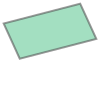

In [49]:
# new columns about slow zone
inSZ = []

# Load Slow Zone data
geo_data = folium.GeoJson(path_sz[0], name="geojson")
feature = geo_data.data['features'][0]
coor = feature['geometry']['coordinates']
polygon = Polygon(coor[0])
polygon 

In [50]:
# iter through the new data and check if the ship is in the slow zone or not

for i in range(0, len(new_data)):
  m_point = Point(new_data['Lon'][i], new_data['Lat'][i])
  if m_point.within(polygon): 
    inSZ.append(1)
  else: 
    inSZ.append(0)

new_data['InSZ'] = inSZ
new_data[new_data['InSZ'] != 0]

,index,MMSI,UTC_Timestamp,Lat,Lon,SOG,Heading,TransceiverClass,InSZ
16,158,249338000,2020-04-01 07:59:55,41.11581,-71.42003,10.3,138.0,A,1
17,159,249338000,2020-04-01 08:31:16,41.04628,-71.34540,10.3,138.0,A,1
18,160,249338000,2020-04-01 09:01:25,40.99417,-71.25926,10.2,125.0,A,1
19,162,249338000,2020-04-01 10:03:36,40.88553,-71.07983,10.1,128.0,A,1
20,163,249338000,2020-04-01 10:33:36,40.82937,-70.99812,10.1,128.0,A,1
...,...,...,...,...,...,...,...,...,...
15703,318611,367402280,2020-04-30 17:50:40,41.14536,-70.98479,10.2,511.0,B,1
15705,319625,367494810,2020-04-30 01:32:10,41.29380,-70.81046,10.1,316.0,A,1
15789,325246,368135940,2020-04-30 16:39:34,40.78045,-71.51466,10.1,22.0,A,1
15790,325247,368135940,2020-04-30 17:10:40,40.86111,-71.47654,10.3,20.0,A,1


## Check if the ship is in the Whale Habitat or not and check the habitat score at that location

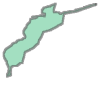

In [57]:
raster_val = []

for i in range(0, len(geoms)):
  geo_j = geoms[i]['geometry']
  polygon = Polygon(geo_j['coordinates'][0])
  if (geoms[i]['properties']['raster_val'] != 0):
    polygons.append(polygon)
    raster_val.append(round(geoms[i]['properties']['raster_val'], 2))

u = unary_union(polygons)
u

In [58]:
np.unique(raster_val)

array([0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18,
       0.19, 0.2 , 0.22, 0.23, 0.25, 0.26, 0.31, 0.33])

In [67]:
df_polygon = pd.DataFrame()
polygon_col = []
habitat_score = []

for i in range(0, len(geoms)):
  geo_j = geoms[i]['geometry']
  polygon = Polygon(geo_j['coordinates'][0])
  if (round(geoms[i]['properties']['raster_val'] != 0)):
    polygon_col.append(polygon)
    habitat_score.append(round(geoms[i]['properties']['raster_val'], 2))

df_polygon['Polygon'] = polygon_col
df_polygon['Habitat'] = habitat_score

df_polygon.head()

,Polygon,Habitat
0,"POLYGON ((-67.14710462577482 44.7730401785405,...",0.08
1,POLYGON ((-67.26143846109365 44.65870634322167...,0.08
2,POLYGON ((-67.14710462577482 44.65870634322167...,0.08
3,POLYGON ((-55.71372109389151 44.65870634322167...,0.08
4,POLYGON ((-67.71877380236899 44.54437250790284...,0.08


In [70]:
habitat_dict = np.unique(raster_val)

array([0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18,
       0.19, 0.2 , 0.22, 0.23, 0.25, 0.26, 0.31, 0.33])

In [72]:
# array of polygons that have the same habitat score
new_polygons = []

for i in range(0, len(habitat_dict)):
  new_polygon_df = df_polygon[df_polygon['Habitat'] == habitat_dict[i]]
  new_polygon_df = new_polygon_df.reset_index()
  polygons = []
  for j in range(0, len(new_polygon_df)):
    polygon = new_polygon_df['Polygon'][j]
    polygons.append(polygon)
  u = unary_union(polygons)
  new_polygons.append(u)

In [83]:
new_data_habitat = []

# for i in range(0, len(new_data)):
#   m_habitat = 0
#   point = Point(new_data['Lon'][i], new_data['Lat'][i])
#   for j in range(0, len(new_polygons)):
#     if new_polygons[j].contains(point):
#       m_habitat = habitat_dict[j]
#   new_data_habitat.append(m_habitat)

# len(new_data_habitat)
# for i in range(0, len(new_data)):
#   m_point = Point(new_data['Lon'][i], new_data['Lat'][i])

for i in range(0, len(new_data)): 
  point = Point(new_data['Lon'][i], new_data['Lat'][i])
  m_habitat = 0

  for j in range(0, len(new_polygons)):
      if new_polygons[j].contains(point):
        m_habitat = habitat_dict[j]

  new_data_habitat.append(m_habitat)

len(new_data_habitat)

15921

In [84]:
new_data['Habitat_Score'] = new_data_habitat

In [85]:
new_data.head()

,index,MMSI,UTC_Timestamp,Lat,Lon,SOG,Heading,TransceiverClass,InSZ,Habitat_Score
0,95,244584000,2020-04-01 00:03:30,40.43278,-68.64723,13.7,50.0,A,0,0.08
1,96,244584000,2020-04-01 00:37:36,40.51240,-68.51300,14.0,51.0,A,0,0.08
2,97,244584000,2020-04-01 01:10:48,40.58868,-68.37947,14.2,51.0,A,0,0.08
3,98,244584000,2020-04-01 01:56:17,40.69613,-68.19885,13.8,51.0,A,0,0.08
4,99,244584000,2020-04-01 02:56:55,40.84313,-67.94903,14.7,54.0,A,0,0.08
